In [1]:
#   bem: triangulation and fmm/bem electrostatics tools 
#
#   Copyright (C) 2011-2012 Robert Jordens <jordens@gmail.com>
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

# `bem` 3D electrostatics example

In [1]:
import sys
import logging, os
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../../')
sys.path.append('../../../electrode/')

from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
from bem.formats import stl

In [2]:
# base file name for outputs and inputs is the script name
try:
    # works only if we are a script
    prefix = os.path.splitext(__file__)[0]
except NameError:
    # fallback for notebooks
    prefix = "SimpleTrap"

In [3]:
# scale to natural units (ion height)
scale = 40e-6
use_stl = True

if not use_stl:
    # load electrode faces from loops
    ele = Electrodes.from_trap(open("%s.ele" % prefix), scale)
    # initial triangulation, area 20, quiet
    mesh = Mesh.from_electrodes(ele)
    mesh.triangulate(opts="qa10Q")
else:
    # load electrode faces from colored stl
    s = stl.read_stl(open("%s.stl" % prefix, "rb"))
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s, scale=scale/1e-6,
        rename={9495: "DC1", 17962: "DC3", 18994: "DC5",
        18869: "DC2", 20943: "RF", 18129: "DC4"}))

dropping 0
1 planes in electrode DC1
Normals vectors are:
 [[ 0. -0.  1.]]
1 planes in electrode DC3
Normals vectors are:
 [[0. 0. 1.]]
1 planes in electrode DC5
Normals vectors are:
 [[0. 0. 1.]]
1 planes in electrode DC2
Normals vectors are:
 [[0. 0. 1.]]
1 planes in electrode RF
Normals vectors are:
 [[0. 0. 1.]]
1 planes in electrode DC4
Normals vectors are:
 [[ 0. -0.  1.]]


In [4]:
def run_job(args):
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min
    # angle 25deg
    job.adapt_mesh(triangles=4e2, opts="q25Q")
    job.adapt_mesh(triangles=1e3, opts="q25Q")
    # solve for charges
    job.solve_singularities(num_lev=3)
    # get potentials and fields
    result = job.simulate(grid, field=job.name=="RF", num_lev=1)
    result.to_vtk(prefix)
    print("finished job %s" % job.name)
    return job.collect_charges()

In [5]:
# set .1 max area within 3
mesh.areas_from_constraints(Sphere(center=np.array([0, 0, 1.]),
           radius=2, inside=.2, outside=10.))
# retriangulate quality and quiet with areas
mesh.triangulate(opts="qQ", new=False)
# save base mesh to vtk
mesh.to_vtk(prefix)
# grid to evalute potential and fields at
n, s = 2*10, .1
grid = Grid(center=(0, 0, 1.5), step=(s, s, s), shape=(n, n, n))
# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*", "RF"))
# run the different electrodes on the parallel pool
#pmap = Pool().map # parallel map
pmap = map # serial map
list(pmap(run_job, ((job, grid, prefix) for job in jobs)))  # In python 3, convert map(...) to list(map(...))

finished job DC1
finished job DC3
finished job DC5
finished job DC2
finished job RF
finished job DC4


[array([ 4.00734809, -0.94661903, -0.24856346, -0.07062317, -1.61709459,
        -0.12615929]),
 array([-0.91950021,  3.77915375, -0.0709555 , -1.05457779, -0.40032066,
        -0.92167998]),
 array([-0.23101088, -0.06934084,  5.23173514, -0.01437512, -4.3652846 ,
        -0.22761381]),
 array([-0.06896486, -1.10790293, -0.01433094,  1.4050747 , -0.06112265,
        -0.06923268]),
 array([-1.42639098, -0.39154954, -4.35246004, -0.06150771, 10.39154934,
        -1.44321015]),
 array([-0.12590908, -0.94918023, -0.24712495, -0.07108892, -1.62656501,
         4.01451087])]

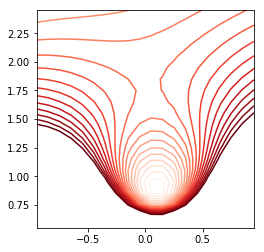

In [6]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix, "RF")
p = result.pseudo_potential
x = grid.to_mgrid()[:, p.shape[0]//2]    # In python 3, use //
p = p[p.shape[0]//2]
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-2, 20), cmap=plt.cm.Reds)

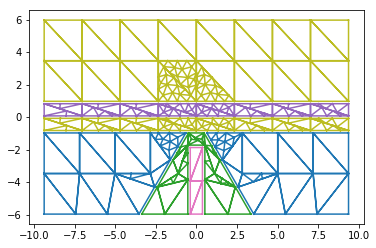

In [7]:
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
mesh.plot(ax)

In [8]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential
Result.view(prefix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook
from pyface.api import GUI
GUI().start_event_loop()

In [8]:
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1 DC2 DC3 DC4 DC5 RF".split():
    r = Result.from_vtk(prefix, name)
    e = GridElectrode.from_result(r)
    e.name = name
    s.append(e)
s["RF"].rf = 1.

../../../electrode/electrode/transformations.py:1911: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


In [9]:
from scipy.constants import atomic_mass
x0 = s.minimum((0, 0, 1.))
for _ in s.analyze_static(x0, m=25*atomic_mass,
                          l=40e-6, o=100e6*2*np.pi):
    print(_)

parameters:
 f=100 MHz, m=25 amu, q=1 qe, l=40 µm, scale=0.0391 V'/V_SI
corrdinates:
 analyze point: [-1.18820049e-04  1.00165222e-01  8.97714323e-01]
               ([-4.75280197e-03  4.00660889e+00  3.59085729e+01] µm)
 minimum is at offset: [0. 0. 0.]
                      ([0. 0. 0.] µm)
potential:
 dc electrical: 0 eV
 rf pseudo: 3.6e-08 eV
 saddle offset: [-2.40996289e-03 -4.75961742e-06 -1.94036633e-06]
               ([-9.63985154e-02 -1.90384697e-04 -7.76146531e-05] µm)
 saddle height: 1e-11 eV
force:
 dc electrical: [0. 0. 0.] eV/l
               ([0. 0. 0.] eV/m)
 rf pseudo: [-1.17144847e-08 -1.26966680e-08 -1.21189616e-10] eV/l
           ([-2.92862117e-04 -3.17416700e-04 -3.02974040e-06] eV/m)
modes:
 pp+dc normal curvatures: [-3.59318187e-07  2.85697360e-01  2.85743827e-01]
 motion is bounded: True
 pseudopotential modes:
  a: nan MHz, [9.99997689e-01 1.99215130e-03 8.08653447e-04]
  b: 4.178 MHz, [-5.05215990e-04  5.83310533e-01 -8.12249079e-01]
  c: 4.178 MHz, [-0.00208

../../../electrode/electrode/system.py:879: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)


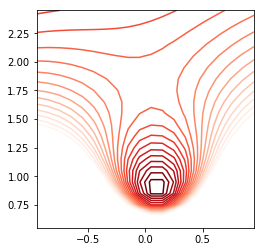

In [10]:
n = 30
#xyz = np.mgrid[-.1:.1:1j*n, -.1:.1:1j*n, 1.12:2]
#xyz = np.mgrid[0:1, -.02:.02:1j*n, .5:1.5:1j*n]
xyz = grid.to_mgrid()
p = s.potential(xyz.reshape(3, -1).T, 0).reshape(xyz[0].shape)
v = np.linspace(0, 2e-2, 21)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyz[1, 10, :, :], xyz[2, 10, :, :], p[10, :, :], v, cmap=plt.cm.Reds_r)